<a href="https://colab.research.google.com/github/TrushaT/CutMix-CutOut-Data-Augmentation-/blob/main/CutMix_%26_CutOut_Data_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

####Importing Libraries and Fashion MNIST dataset

In [1]:
# !pip install tensorflow==2.8.0

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.utils import to_categorical

In [3]:
# install helper utilities
!git clone https://github.com/liady/ssp19ai_utils.git
!git -C ssp19ai_utils pull
import ssp19ai_utils.utils as utils
import importlib
importlib.reload(utils)

Cloning into 'ssp19ai_utils'...
remote: Enumerating objects: 78, done.
remote: Total 78 (delta 0), reused 0 (delta 0), pack-reused 78
Unpacking objects: 100% (78/78), done.
Already up to date.


<module 'ssp19ai_utils.utils' from '/content/ssp19ai_utils/utils.py'>

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


About the dataset: 
- The Fashion MNIST dataset which contains 70,000 images in 10 
categories. 
- The images show individual articles of clothing at low resolution (28 by 28 pixels)
- 60,000 images are used to train the network and 10,000 images to evaluate how accurately the network learned to classify images.

In [5]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


The images are 28x28 NumPy arrays, with pixel values ranging from 0 to 255. The *labels* are an array of integers, ranging from 0 to 9. These correspond to the *class* of clothing the image represents:

<table>
  <tr>
    <th>Label</th>
    <th>Class</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>


In [6]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

#### Data Exploration & preprocessing

In [7]:
print(train_images.shape)
print(train_labels)
print(test_images.shape)

(60000, 28, 28)
[9 0 0 ... 3 0 5]
(10000, 28, 28)


Observations: 
- Each label is an integer between 0 and 9 
- There are 10,000 images in the test set. Again, each image is represented as 28 x 28 pixels.(Note: images are not 3 dimensions)
- Data must be preprocessed before training the network.

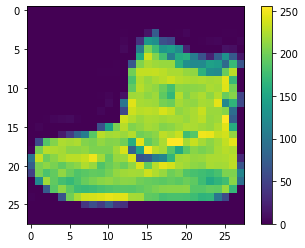

In [8]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

Here as we can see pixel values fall in range of 0 to 255. Therefore scaling these values to a range of 0 to 1 before feeding them to the neural network model. To do so, divide the values by 255.Also image size is 2d therefore needs to be made 3d

Defining hyperparameters

In [9]:
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 32
IMG_SIZE = 28

In [10]:
#Both training reshaped to make it 3 dimension
#Also labels are converted to one hot tensors 

X_train = train_images.reshape((train_images.shape[0], 28, 28, 1))
y_train = to_categorical(train_labels)

X_test =  test_images.reshape((test_images.shape[0], 28, 28, 1))
y_test = to_categorical(test_labels)

In [11]:
def preprocess_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.image.convert_image_dtype(image, tf.float32) / 255.0
    return image, label

Creating Tensorflow Input pipeline - 
Let's convert data to Tensorflow Dataset objects. 

In [12]:
train_ds_one = (
    tf.data.Dataset.from_tensor_slices((X_train, y_train))
    .shuffle(1024)
    .map(preprocess_image, num_parallel_calls=AUTO)
)
train_ds_two = (
    tf.data.Dataset.from_tensor_slices((X_train, y_train))
    .shuffle(1024)
    .map(preprocess_image, num_parallel_calls=AUTO)
)

train_ds_simple = tf.data.Dataset.from_tensor_slices((X_train, y_train))

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_ds_simple = (
    train_ds_simple.map(preprocess_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# Combine two shuffled datasets from the same training data.
train_ds = tf.data.Dataset.zip((train_ds_one, train_ds_two))

test_ds = (
    test_ds.map(preprocess_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

### Cut mix data augmentation strategy

##### Step by Step Detailed Explaination of basic Cutmix strategy 



Cutmix is a data augmentation technique where patch from one random image is extracted and is added to another image creating a new image. 

(28, 28, 1)
(28, 28)
(1, 18, 17)
(28, 28, 1)


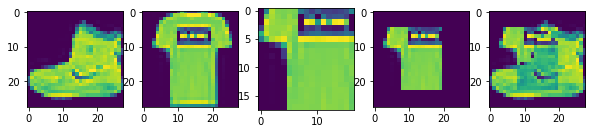

In [20]:
#Let's first understand crux of cutmix and perform on 2 sample images. 
import cv2

IM_SIZE = 28

plt.figure(figsize = (10,10))

plt.subplot(1,5,1)
image_1 = X_train[0]
image_1 = cv2.resize(image_1,(IM_SIZE,IM_SIZE))
plt.imshow(image_1)

plt.subplot(1,5,2)
image_2 = X_train[1]
print(image_2.shape)
image_2 = cv2.resize(image_2,(IM_SIZE,IM_SIZE))
print(image_2.shape)
plt.imshow(image_2)

plt.subplot(1,5,3)
crop = tf.image.crop_to_bounding_box(X_train[1],5,3,18,17)
crop = crop.numpy().transpose(2,0,1)
print(crop.shape)
plt.imshow(crop[0])

plt.subplot(1,5,4)
crop = tf.image.crop_to_bounding_box(X_train[1],5,3,18,17)
image_4 = tf.image.pad_to_bounding_box(crop,5,3,IM_SIZE,IM_SIZE)
print(image_4.shape)
image_4 = image_4.numpy().transpose(2,0,1)
plt.imshow(image_4[0])

plt.subplot(1,5,5)
crop = tf.image.crop_to_bounding_box(X_train[1],5,3,18,17)
image_4 = tf.image.pad_to_bounding_box(crop,5,3,IM_SIZE,IM_SIZE)
image_4 = image_4.numpy().transpose(2,0,1)
plt.imshow(image_4[0]+image_1)

##### Creating Cutmix function and applying on fashion mnist dataset 

In [21]:
def sample_beta_distribution(size, concentration_0=0.2, concentration_1=0.2):
    gamma_1_sample = tf.random.gamma(shape=[size], alpha=concentration_1)
    gamma_2_sample = tf.random.gamma(shape=[size], alpha=concentration_0)
    return gamma_1_sample / (gamma_1_sample + gamma_2_sample)

In [22]:
@tf.function
def get_box(lambda_value):
    cut_rat = tf.math.sqrt(1.0 - lambda_value)

    cut_w = IMG_SIZE * cut_rat  # rw
    cut_w = tf.cast(cut_w, tf.int32)

    cut_h = IMG_SIZE * cut_rat  # rh
    cut_h = tf.cast(cut_h, tf.int32)

    cut_x = tf.random.uniform((1,), minval=0, maxval=IMG_SIZE, dtype=tf.int32)  # rx
    cut_y = tf.random.uniform((1,), minval=0, maxval=IMG_SIZE, dtype=tf.int32)  # ry

    boundaryx1 = tf.clip_by_value(cut_x[0] - cut_w // 2, 0, IMG_SIZE)
    boundaryy1 = tf.clip_by_value(cut_y[0] - cut_h // 2, 0, IMG_SIZE)
    bbx2 = tf.clip_by_value(cut_x[0] + cut_w // 2, 0, IMG_SIZE)
    bby2 = tf.clip_by_value(cut_y[0] + cut_h // 2, 0, IMG_SIZE)

    target_h = bby2 - boundaryy1
    if target_h == 0:
        target_h += 1

    target_w = bbx2 - boundaryx1
    if target_w == 0:
        target_w += 1

    return boundaryx1, boundaryy1, target_h, target_w

In [23]:
@tf.function
def cutmix(train_ds_one, train_ds_two):
    (image1, label1), (image2, label2) = train_ds_one, train_ds_two

    alpha = [0.25]
    beta = [0.25]

    # Get a sample from the Beta distribution
    lambda_value = sample_beta_distribution(1, alpha, beta)

    # Define Lambda
    lambda_value = lambda_value[0][0]

    # Get the bounding box offsets, heights and widths
    boundaryx1, boundaryy1, target_h, target_w = get_box(lambda_value)

    # Get a patch from the second image (`image2`)
    crop2 = tf.image.crop_to_bounding_box(
        image2, boundaryy1, boundaryx1, target_h, target_w
    )
    # Pad the `image2` patch (`crop2`) with the same offset
    image2 = tf.image.pad_to_bounding_box(
        crop2, boundaryy1, boundaryx1, IMG_SIZE, IMG_SIZE
    )
    # Get a patch from the first image (`image1`)
    crop1 = tf.image.crop_to_bounding_box(
        image1, boundaryy1, boundaryx1, target_h, target_w
    )
    # Pad the `image1` patch (`crop1`) with the same offset
    img1 = tf.image.pad_to_bounding_box(
        crop1, boundaryy1, boundaryx1, IMG_SIZE, IMG_SIZE
    )

    # Modify the first image by subtracting the patch from `image1`
    # (before applying the `image2` patch)
    image1 = image1 - img1
    # Add the modified `image1` and `image2`  together to get the CutMix image
    image = image1 + image2

    # Adjust Lambda in accordance to the pixel ration
    lambda_value = 1 - (target_w * target_h) / (IMG_SIZE * IMG_SIZE)
    lambda_value = tf.cast(lambda_value, tf.float32)

    # Combine the labels of both images
    label = lambda_value * label1 + (1 - lambda_value) * label2
    return image, label

##### New dataset after Cutmix augmentation 

In [24]:
# Create the new dataset using our `cutmix` utility
train_ds_cmu = (
    train_ds.shuffle(1024)
    .map(cutmix, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

In [28]:
train_ds_cmu.cardinality().numpy()

1875

1875 images were created. 

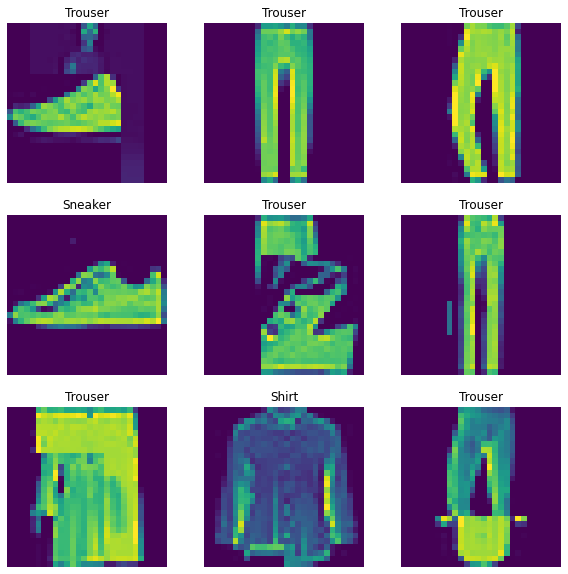

In [23]:
# Let's preview 9 samples from the dataset
image_batch, label_batch = next(iter(train_ds_cmu))
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.title(class_names[np.argmax(label_batch[i])])
    plt.imshow(image_batch[i].numpy().transpose(2,0,1)[0])
    plt.axis("off")

In [24]:
len(image_batch)

32

###Cutout data augmentation 

Cutout is a data augmentation technique that generally designates the process of obfuscating square regions of an image

In [29]:
!pip install tensorflow-addons==0.9.1

     |████████████████████████████████| 1.0 MB 13.3 MB/s 


In [30]:
import tensorflow_addons as tfa
@tf.function 
def random_cut_out(images, labels):
    return tfa.image.random_cutout(images, (10, 10), constant_values = 1), labels

/usr/local/lib/python3.7/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:68: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.1.0 and strictly below 2.3.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


In [31]:
# Create the new dataset using our `cutout` utility
train_ds_cutout = (
    train_ds_simple.shuffle(1024)
    .map(random_cut_out, num_parallel_calls=AUTO)
)

In [32]:
train_ds_cutout.cardinality().numpy()

1875

1875 cutout images were created.

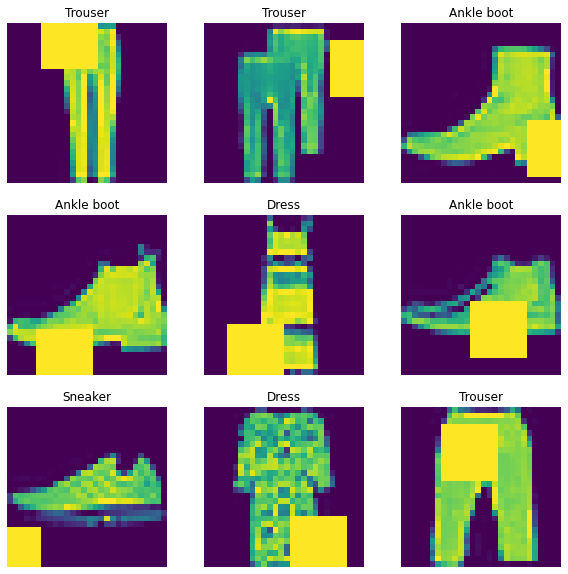

In [30]:
# Let's preview 9 samples from the dataset
image_batch, label_batch = next(iter(train_ds_cutout))
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.title(class_names[np.argmax(label_batch[i])])
    plt.imshow(image_batch[i].numpy().transpose(2,0,1)[0])
    plt.axis("off")

###Mixed Combination 

In [34]:
# Combine two shuffled cutmix and cutout datasets 
train_ds_m = train_ds_cmu.concatenate(train_ds_cutout)

train_ds_mixed = (
    train_ds_m.shuffle(1024)
)

In [35]:
train_ds_mixed

<ShuffleDataset element_spec=(TensorSpec(shape=(None, 28, 28, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [36]:
train_ds_mixed.cardinality().numpy()

3750

Combination of 3750 images obtained in mixed.

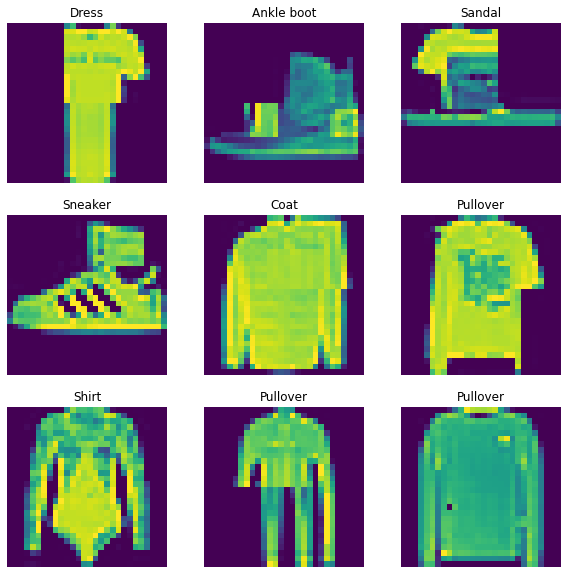

In [125]:
# Let's preview 9 samples from the dataset
image_batch, label_batch = next(iter(train_ds_mixed))
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.title(class_names[np.argmax(label_batch[i])])
    plt.imshow(image_batch[i].numpy().transpose(2,0,1)[0])
    plt.axis("off")

### AlexNet model 

####Model 

In [13]:
# Implementing custom AlexNet model 
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization
from keras.regularizers import l2

def alexnet_model(img_shape=(28, 28, 1), n_classes=10, l2_reg=0.,
	weights=None):

	# Initialize model
	alexnet = Sequential()

	# Layer 1
	alexnet.add(Conv2D(96, (11, 11), input_shape=img_shape,
		padding='same', kernel_regularizer=l2(l2_reg)))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))
	alexnet.add(MaxPooling2D(pool_size=(2, 2)))

	# Layer 2
	alexnet.add(Conv2D(256, (5, 5), padding='same'))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))
	alexnet.add(MaxPooling2D(pool_size=(2, 2)))

	# Layer 3
	alexnet.add(ZeroPadding2D((1, 1)))
	alexnet.add(Conv2D(512, (3, 3), padding='same'))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))
	alexnet.add(MaxPooling2D(pool_size=(2, 2)))

	# Layer 4
	alexnet.add(ZeroPadding2D((1, 1)))
	alexnet.add(Conv2D(1024, (3, 3), padding='same'))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))

	# Layer 5
	alexnet.add(ZeroPadding2D((1, 1)))
	alexnet.add(Conv2D(1024, (3, 3), padding='same'))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))
	alexnet.add(MaxPooling2D(pool_size=(2, 2)))

	# Layer 6
	alexnet.add(Flatten())
	alexnet.add(Dense(3072))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))
	alexnet.add(Dropout(0.5))

	# Layer 7
	alexnet.add(Dense(4096))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))
	alexnet.add(Dropout(0.5))

	# Layer 8
	alexnet.add(Dense(n_classes))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('softmax'))

	if weights is not None:
		alexnet.load_weights(weights)

	return alexnet

In [14]:
model = alexnet_model()

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 96)        11712     
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 96)       384       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 28, 28, 96)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 256)      1

#### Model for cutmixed data augmentation 

In [23]:
model = alexnet_model()

#####Model Training & evaluation 

In [ ]:
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics=['accuracy'])

In [ ]:
history = model.fit(train_ds_cmu, validation_data=test_ds, epochs=15)

Epoch 1/15
1875/1875 [==============================] - 123s 58ms/step - loss: 1.1697 - accuracy: 0.6914 - val_loss: 0.5801 - val_accuracy: 0.8161
Epoch 2/15
1875/1875 [==============================] - 109s 58ms/step - loss: 0.9846 - accuracy: 0.7460 - val_loss: 0.4349 - val_accuracy: 0.8566
Epoch 3/15
1875/1875 [==============================] - 110s 59ms/step - loss: 0.9115 - accuracy: 0.7642 - val_loss: 0.4130 - val_accuracy: 0.8678
Epoch 4/15
1875/1875 [==============================] - 108s 58ms/step - loss: 0.8655 - accuracy: 0.7778 - val_loss: 0.3340 - val_accuracy: 0.8943
Epoch 5/15
1875/1875 [==============================] - 111s 59ms/step - loss: 0.8368 - accuracy: 0.7853 - val_loss: 0.3158 - val_accuracy: 0.9036
Epoch 6/15
1875/1875 [==============================] - 108s 58ms/step - loss: 0.8177 - accuracy: 0.7887 - val_loss: 0.2884 - val_accuracy: 0.9099
Epoch 7/15
1875/1875 [==============================] - 109s 58ms/step - loss: 0.7881 - accuracy: 0.8003 - val_loss: 0

In [ ]:
test_loss, test_accuracy = model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_accuracy * 100))

313/313 [==============================] - 5s 16ms/step - loss: 0.2870 - accuracy: 0.9105
Test accuracy: 91.05%


In [ ]:
model.save_weights("/content/drive/MyDrive/alexnet_model_weights_cutmix.h5")
model.save("/content/drive/MyDrive/alexnet_model_cutmix.h5")

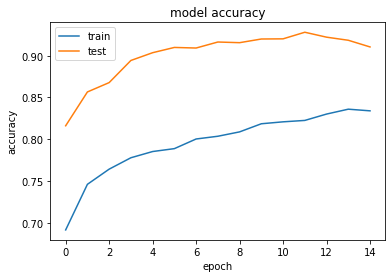

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

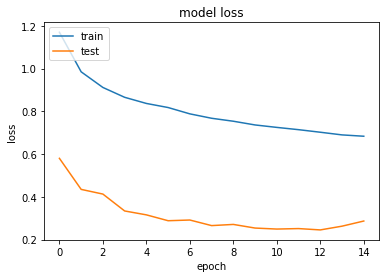

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#####Making Predictions 

In [ ]:
predictions = model.predict(test_ds)

In [ ]:
predictions[0]

array([3.3215777e-04, 2.5718494e-03, 4.5163027e-04, 1.1085862e-03,
       7.9972838e-04, 1.6911514e-02, 3.5125366e-03, 6.4546014e-03,
       3.3654349e-03, 9.6449196e-01], dtype=float32)

In [ ]:
predictions[0].argmax()

9

In [ ]:
test_labels[0]

9

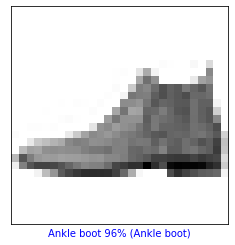

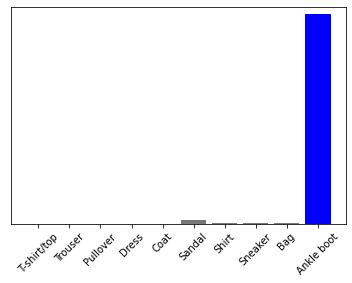

In [ ]:
# Show the 0th image:
index = 0
utils.plot_image_and_prob(predictions, test_labels, test_images, i=index, big=True, class_names=class_names)

Confusion matrix


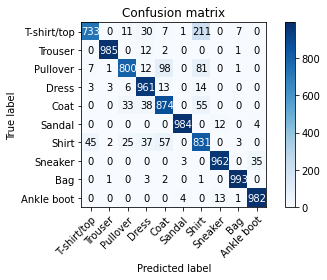

In [ ]:
# As always - let's convert the probabilities array into classes
predicted_classes = utils.label_with_highest_prob(predictions)

# Plot the matrix
utils.plot_confusion_matrix(y_pred=predicted_classes, y_true=test_labels, classes=np.array(class_names))

In [ ]:
from sklearn.metrics import classification_report,roc_curve,confusion_matrix
print('Classification Report\n',classification_report(test_labels, predicted_classes))

Classification Report
               precision    recall  f1-score   support

           0       0.93      0.73      0.82      1000
           1       0.99      0.98      0.99      1000
           2       0.91      0.80      0.85      1000
           3       0.88      0.96      0.92      1000
           4       0.83      0.87      0.85      1000
           5       0.99      0.98      0.99      1000
           6       0.70      0.83      0.76      1000
           7       0.97      0.96      0.97      1000
           8       0.99      0.99      0.99      1000
           9       0.96      0.98      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.92      0.91      0.91     10000
weighted avg       0.92      0.91      0.91     10000



#### Model for images which are cutout augmented 

In [32]:
model = alexnet_model()

#####Model training & evaluation 

In [33]:
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics=['accuracy'])

In [34]:
history = model.fit(train_ds_cutout, validation_data=test_ds, epochs=15)

Epoch 1/15
1875/1875 [==============================] - 132s 63ms/step - loss: 0.6898 - accuracy: 0.7890 - val_loss: 0.5140 - val_accuracy: 0.8324
Epoch 2/15
1875/1875 [==============================] - 117s 62ms/step - loss: 0.4592 - accuracy: 0.8489 - val_loss: 0.3468 - val_accuracy: 0.8857
Epoch 3/15
1875/1875 [==============================] - 115s 61ms/step - loss: 0.3864 - accuracy: 0.8701 - val_loss: 0.4280 - val_accuracy: 0.8296
Epoch 4/15
1875/1875 [==============================] - 114s 60ms/step - loss: 0.3431 - accuracy: 0.8825 - val_loss: 0.2957 - val_accuracy: 0.8940
Epoch 5/15
1875/1875 [==============================] - 114s 60ms/step - loss: 0.3048 - accuracy: 0.8940 - val_loss: 0.2813 - val_accuracy: 0.9011
Epoch 6/15
1875/1875 [==============================] - 114s 60ms/step - loss: 0.2757 - accuracy: 0.9028 - val_loss: 0.2486 - val_accuracy: 0.9113
Epoch 7/15
1875/1875 [==============================] - 119s 63ms/step - loss: 0.2514 - accuracy: 0.9106 - val_loss: 0

In [35]:
test_loss, test_accuracy = model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_accuracy * 100))

313/313 [==============================] - 5s 15ms/step - loss: 0.2632 - accuracy: 0.9176
Test accuracy: 91.76%


In [36]:
model.save_weights("/content/drive/MyDrive/alexnet_model_weights_cutout.h5")
model.save("/content/drive/MyDrive/alexnet_model_cutout.h5")

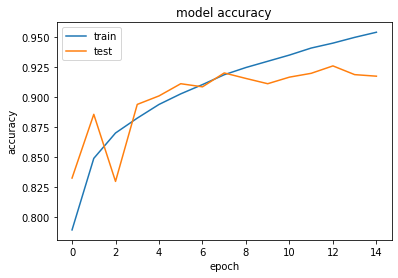

In [37]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

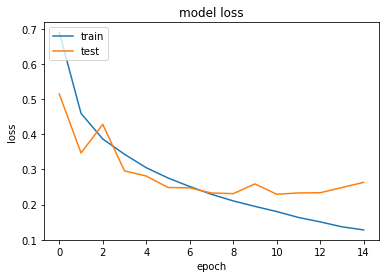

In [38]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#####Making Predictions 

In [39]:
predictions = model.predict(test_ds)

In [40]:
predictions[0]

array([1.1013133e-04, 4.8961541e-05, 9.0860949e-06, 2.0722489e-05,
       3.5550707e-05, 3.9456002e-04, 8.2838109e-05, 1.2159849e-05,
       1.1791211e-04, 9.9916804e-01], dtype=float32)

In [41]:
predictions[0].argmax()

9

In [42]:
test_labels[0]

9

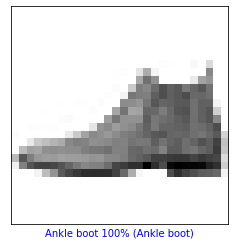

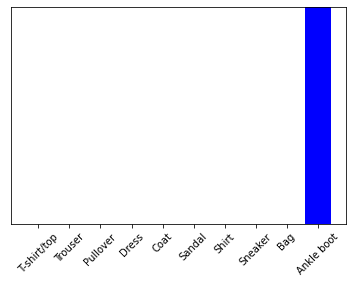

In [43]:
# Show the 0th image:
index = 0
utils.plot_image_and_prob(predictions, test_labels, test_images, i=index, big=True, class_names=class_names)

Confusion matrix


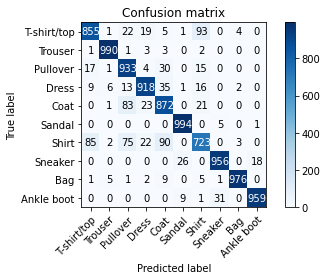

In [44]:
# As always - let's convert the probabilities array into classes
predicted_classes = utils.label_with_highest_prob(predictions)

# Plot the matrix
utils.plot_confusion_matrix(y_pred=predicted_classes, y_true=test_labels, classes=np.array(class_names))

In [45]:
from sklearn.metrics import classification_report,roc_curve,confusion_matrix
print('Classification Report\n',classification_report(test_labels, predicted_classes))

Classification Report
               precision    recall  f1-score   support

           0       0.88      0.85      0.87      1000
           1       0.98      0.99      0.99      1000
           2       0.83      0.93      0.88      1000
           3       0.93      0.92      0.92      1000
           4       0.84      0.87      0.85      1000
           5       0.96      0.99      0.98      1000
           6       0.83      0.72      0.77      1000
           7       0.96      0.96      0.96      1000
           8       0.99      0.98      0.98      1000
           9       0.98      0.96      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



#### Model for images which are mixed augmented 

In [126]:
model = alexnet_model()

#####Model training & evaluation 

In [127]:
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics=['accuracy'])

In [128]:
history = model.fit(train_ds_mixed, validation_data=test_ds, epochs=15)

Epoch 1/15
3750/3750 [==============================] - 231s 59ms/step - loss: 0.8430 - accuracy: 0.7675 - val_loss: 0.4286 - val_accuracy: 0.8579
Epoch 2/15
3750/3750 [==============================] - 229s 59ms/step - loss: 0.6591 - accuracy: 0.8234 - val_loss: 0.3334 - val_accuracy: 0.8784
Epoch 3/15
3750/3750 [==============================] - 229s 59ms/step - loss: 0.5870 - accuracy: 0.8429 - val_loss: 0.3693 - val_accuracy: 0.8721
Epoch 4/15
3750/3750 [==============================] - 230s 59ms/step - loss: 0.5377 - accuracy: 0.8592 - val_loss: 0.2903 - val_accuracy: 0.8982
Epoch 5/15
3750/3750 [==============================] - 230s 59ms/step - loss: 0.5036 - accuracy: 0.8682 - val_loss: 0.2561 - val_accuracy: 0.9083
Epoch 6/15
3750/3750 [==============================] - 230s 59ms/step - loss: 0.4728 - accuracy: 0.8777 - val_loss: 0.2073 - val_accuracy: 0.9281
Epoch 7/15
3750/3750 [==============================] - 229s 59ms/step - loss: 0.4505 - accuracy: 0.8870 - val_loss: 0

In [129]:
test_loss, test_accuracy = model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_accuracy * 100))

313/313 [==============================] - 5s 15ms/step - loss: 0.2405 - accuracy: 0.9289
Test accuracy: 92.89%


In [130]:
model.save_weights("/content/drive/MyDrive/alexnet_model_weights_mixed.h5") 
model.save("/content/drive/MyDrive/alexnet_model_mixed.h5")

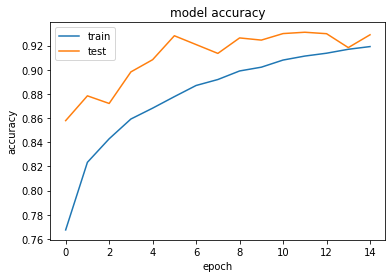

In [131]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

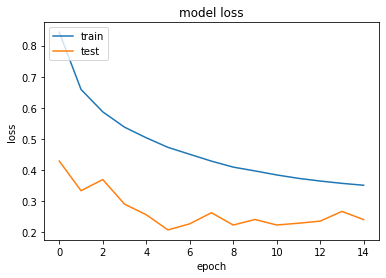

In [132]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#####Making Predictions 

In [133]:
predictions = model.predict(test_ds)

In [134]:
predictions[0]

array([1.1811587e-05, 1.7659706e-05, 2.1571366e-06, 4.5046527e-06,
       4.1524439e-05, 7.9337260e-05, 2.7370204e-05, 6.6051049e-05,
       1.4379822e-05, 9.9973518e-01], dtype=float32)

In [135]:
predictions[0].argmax()

9

In [136]:
test_labels[0]

9

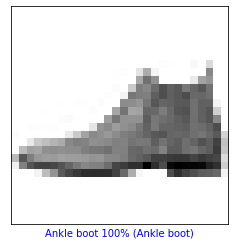

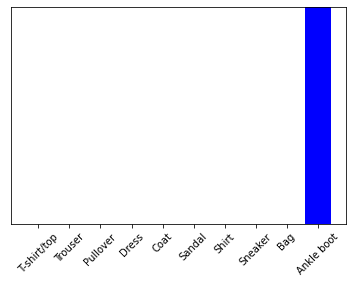

In [137]:
# Show the 0th image:
index = 0
utils.plot_image_and_prob(predictions, test_labels, test_images, i=index, big=True, class_names=class_names)

Confusion matrix


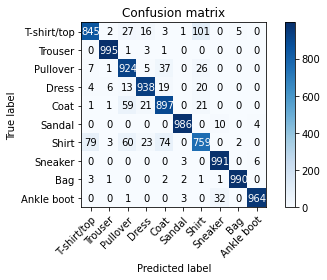

In [138]:
# As always - let's convert the probabilities array into classes
predicted_classes = utils.label_with_highest_prob(predictions)

# Plot the matrix
utils.plot_confusion_matrix(y_pred=predicted_classes, y_true=test_labels, classes=np.array(class_names))

In [139]:
from sklearn.metrics import classification_report,roc_curve,confusion_matrix
print('Classification Report\n',classification_report(test_labels, predicted_classes))

Classification Report
               precision    recall  f1-score   support

           0       0.90      0.84      0.87      1000
           1       0.99      0.99      0.99      1000
           2       0.85      0.92      0.89      1000
           3       0.93      0.94      0.94      1000
           4       0.87      0.90      0.88      1000
           5       0.99      0.99      0.99      1000
           6       0.82      0.76      0.79      1000
           7       0.96      0.99      0.97      1000
           8       0.99      0.99      0.99      1000
           9       0.99      0.96      0.98      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



###Conclusions: 
1. Cutmixed and cutout data augmentation techniques were applied on fashion mnist dataset.  
2. For cutmixed technique accuracy obtained was 91.05% with an average precision of 92 and 91 average recall and 91 F-1 score.Cutmixed worked really good for most classes but performed below average for class T-Shirt/top. 
3. For cutout technique accuracy obtained was 91.76% with an average precision of 92 and 92 average recall and 92 F1-score. One of the reasons could be cause of random cuts, there were some images that were practically not so much distorted as cutmixed.Cutout performed below average for class Shirt class. 
4. A mixture of both type of augmentated dataset was created and accuracy of 92.89% was obtained with an average precision of 93 and 93 average recall and 93 F1-score.This performed below average for class Shirt class. 
